In [1]:
import numpy as np
import random
from PIL import Image
import networkx as nx
from scipy.optimize import curve_fit
import matplotlib.pyplot as plt
%matplotlib widget

from cubic_spline import CubicSpline2D
from cubic_polynomial_fit import CubicPolynomial2D, cubic_func
from extract_network import find_color, extract_network, render_skeleton, render_network

/home/ss/anaconda3/envs/extract_raster/lib/python3.9/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.25.2
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [2]:
def image_to_graph(img: Image, simplify: bool=True) -> nx.Graph:
    rgb = (255, 255, 255)
    px = find_color(img, rgb).T
    return extract_network(px, min_distance=4, simplify=simplify)

def graph_to_polylines(g: nx.Graph, simplify: bool=True) -> list:
    polylines = []
    for (n1, n2, k) in g.edges(keys=True):
        edge = g[n1][n2][k]
        path = edge['path']
        if simplify:
            coords = np.array(path.coords)
        else:
            coords = np.array(path)
        polylines.append(coords)
    return polylines


img_id = 1
gray_file = f'samples/gt/{img_id}_gray.png'
color_file = f'samples/gt/{img_id}_scatter.png'
img_gray = Image.open(gray_file)
img_color = Image.open(color_file)

simplify = False
skel, graph = image_to_graph(img_gray, simplify=simplify)
polylines = graph_to_polylines(graph, simplify=simplify)

Skeleton px=6322
Adding 13/24 dense nodes to existing 307 nodes.
Extracted street network:
  - 152 nodes
  - 366 edges


Found 37 terminal nodes (nodes with only 1 degree connection)
 ** On entry to DLASCL parameter number  4 had an illegal value
 ** On entry to DLASCL parameter number  5 had an illegal value
 ** On entry to DLASCL parameter number  4 had an illegal value
 ** On entry to DLASCL parameter number  5 had an illegal value
 ** On entry to DLASCL parameter number  4 had an illegal value
 ** On entry to DLASCL parameter number  5 had an illegal value
 ** On entry to DLASCL parameter number  4 had an illegal value
 ** On entry to DLASCL parameter number  5 had an illegal value
i = 5, nodes length = 5


/home/ss/anaconda3/envs/extract_raster/lib/python3.9/site-packages/scipy/optimize/minpack.py:833: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


IndexError: list index out of range

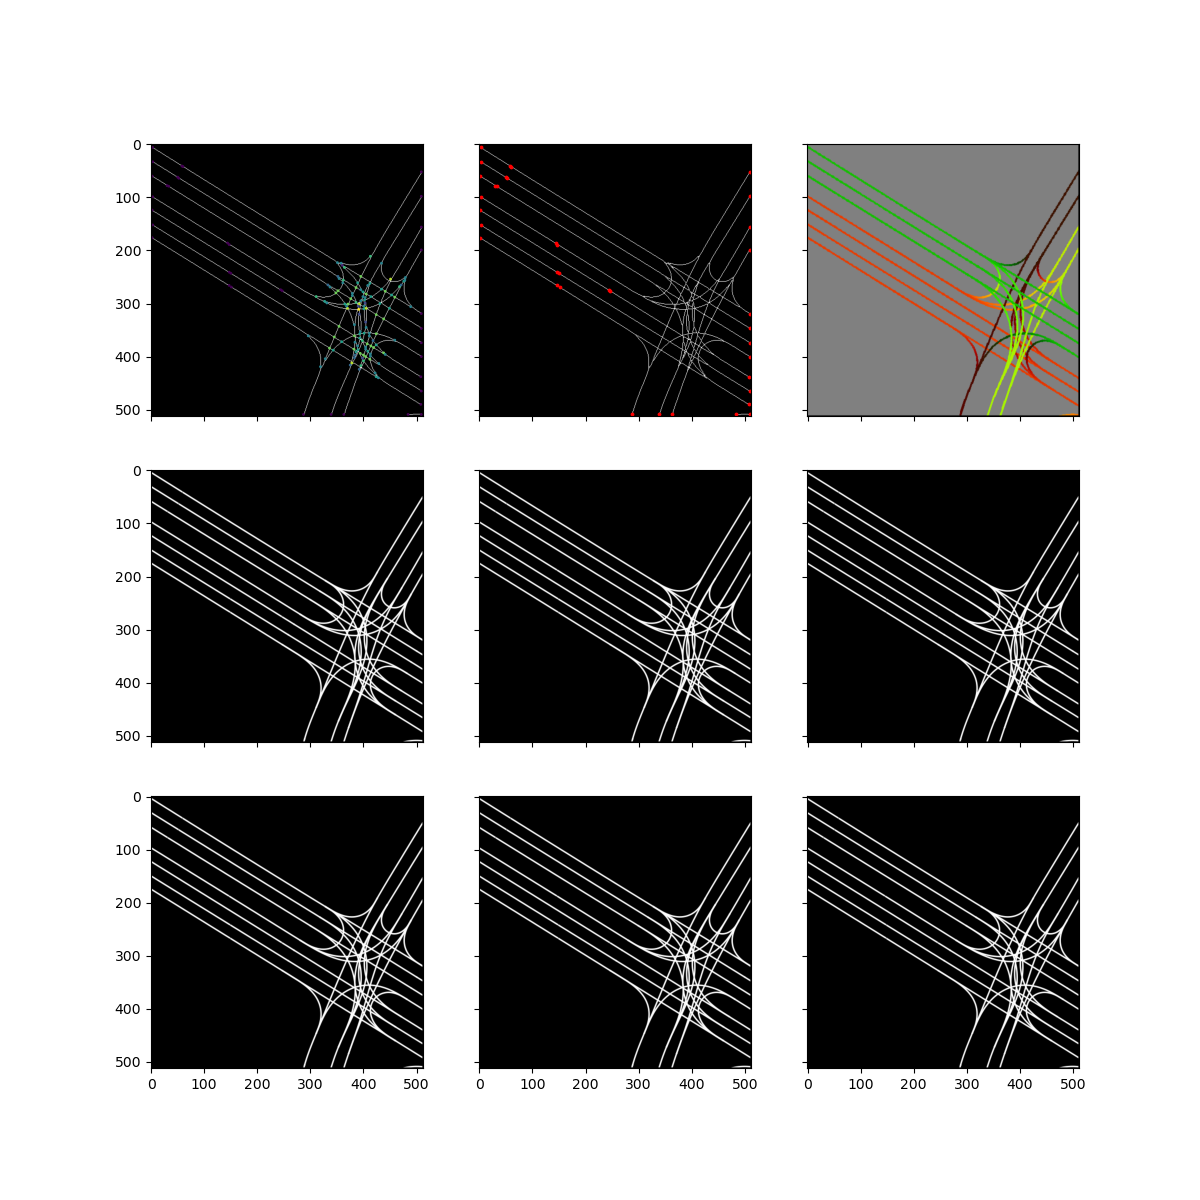

In [3]:
from vectorization import (find_terminal_nodes, connect_small_gaps, reduce_graph, 
                           find_branching_nodes, find_node_directions, 
                           find_paths_among_terminals, normalize_dx_dy, 
                           downsample_path, path_is_smooth, fit_cubic_polynomial)


def connect_terminal_nodes(graph: nx.Graph) -> nx.Graph:

    fig, axes = plt.subplots(3, 3, figsize=(12, 12), sharex=True, sharey=True)
    axes = axes.ravel()
    axes[0].imshow(skel.T, cmap='gray')
    axes[1].imshow(skel.T, cmap='gray')
    axes[2].imshow(img_color)
    axes[3].imshow(img_gray)
    axes[4].imshow(img_gray)
    axes[5].imshow(img_gray)
    axes[6].imshow(img_gray)
    axes[7].imshow(img_gray)
    axes[8].imshow(img_gray)

    # Visualize the nodes, colored by degrees of connectivity
    nodes = np.array([node for (node, degree) in graph.degree()], dtype=float)
    degrees = np.array([degree for (node, degree) in graph.degree()], dtype=float)
    axes[0].scatter(nodes[:, 0], nodes[:, 1], c=degrees, s=1)

    # Fix small gaps in the orignal graph
    nodes_1_degree = find_terminal_nodes(graph)
    graph = connect_small_gaps(graph, nodes_1_degree, thresh=8)
    nodes_1_degree_np = np.array(nodes_1_degree)
    axes[1].scatter(nodes_1_degree_np[:, 0], nodes_1_degree_np[:, 1], c='red', s=3)

    # Simplify the graph
    changed = True
    while changed:
        graph, changed = reduce_graph(graph)

    nodes_terminal = find_terminal_nodes(graph)
    nodes_branching = find_branching_nodes(graph, nodes_terminal)
    nodes_terminal, nodes_branching = find_node_directions(graph, nodes_terminal, nodes_branching, img_color)
    
    nodes_terminal_np = np.array(nodes_terminal)
    nodes_branching_np = np.array(nodes_branching)
    inlets = nodes_branching_np[nodes_branching_np[:, -1] > 0.5]
    outlets = nodes_branching_np[nodes_branching_np[:, -1] < 0.5]
    print(f'found {inlets.shape[0]} inlets, {outlets.shape[0]} outlets')

    axes[2].quiver(inlets[:, 0], inlets[:, 1], inlets[:, 2], inlets[:, 3], 
                   color='r', angles='xy', scale_units='xy', scale=0.1)
    axes[2].quiver(outlets[:, 0], outlets[:, 1], outlets[:, 2], outlets[:, 3], 
                   color='g', angles='xy', scale_units='xy', scale=0.1)
    # axes[2].quiver(nodes_directed_np[:, 0], nodes_directed_np[:, 1], nodes_directed_np[:, 4], nodes_directed_np[:, 5], 
    #                color='b', angles='xy', scale_units='xy', scale=0.1)
    paths, path_waypoints = find_paths_among_terminals(graph, inlets, outlets)

    for path, waypoints in zip(paths, path_waypoints):
        path = np.array(path, dtype=float)
        xs = path[:, 0]
        ys = path[:, 1]
        axes[3].plot(xs, ys)

        dx = np.diff(path[:, 0])
        dy = np.diff(path[:, 1])
        dx, dy = normalize_dx_dy(dx, dy)
        axes[4].quiver(xs[:-1], ys[:-1], dx, dy, color='g', angles='xy', scale_units='xy', scale=0.1)
        
        # yaw = np.arctan2(dy, dx)
        # yaw_diff = np.fabs(np.rad2deg(np.diff(yaw)))
        # if np.all(yaw_diff < 60):
        #     axes[5].plot(xs, ys)

        waypoints = np.array(waypoints, dtype=float)
        waypoints = downsample_path(waypoints, 2)
        if waypoints.shape[0] != 0:
            xs = waypoints[:, 0]
            ys = waypoints[:, 1]
            axes[5].plot(xs, ys)

            if path_is_smooth(waypoints, 60.0):
                axes[7].plot(xs, ys)

            cubic_spline, curve = fit_cubic_polynomial(xs, ys)
            axes[8].plot(curve[:, 0], curve[:, 1])

    axes[0].set_aspect('equal')
    axes[1].set_aspect('equal')
    axes[2].set_aspect('equal')
    axes[3].set_aspect('equal')
    axes[4].set_aspect('equal')
    axes[5].set_aspect('equal')

    plt.show()
    
    return graph

connect_terminal_nodes(graph)

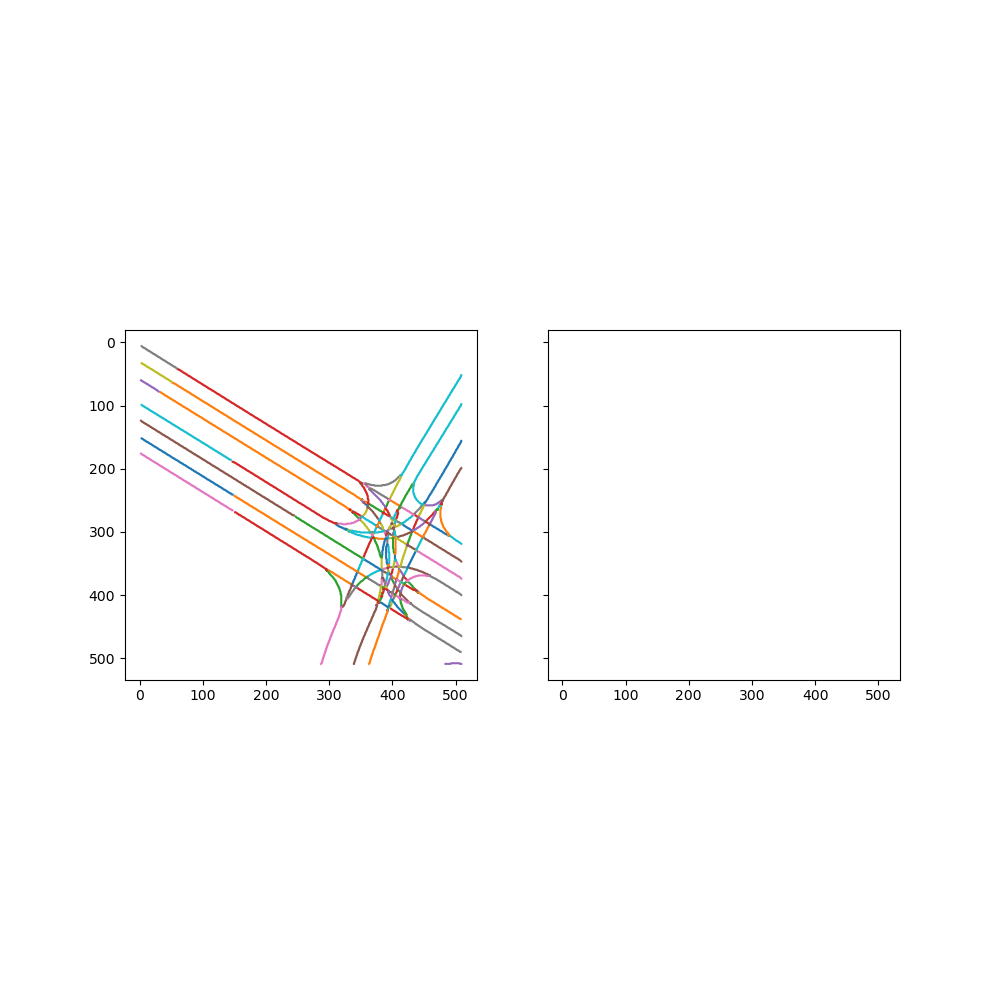

In [ ]:
def plot_polylines(polylines: list) -> None:
    fig, axes = plt.subplots(1, 2, figsize=(10, 10), sharex=True, sharey=True)
    axes = axes.ravel()

    def random_color():
        return '#{:02X}{:02X}{:02X}'.format(random.randint(0, 255), random.randint(0, 255), random.randint(0, 255))
    
    def generate_random_colors(n):
        return [random_color() for _ in range(n)]

    color = generate_random_colors(len(polylines))

    for i, polyline in enumerate(polylines):
        xs = polyline[:, 0]
        ys = polyline[:, 1]
        axes[0].plot(xs, ys)

        # cubic_spline, ref_curve = fit_cubic_polynomial(xs, ys)
        # dy = np.sin(ref_curve[:, 2]) / 5
        # dx = np.cos(ref_curve[:, 2]) / 5
        # axes[1].quiver(ref_curve[:, 0], ref_curve[:, 1], dx, dy, color=color[i], angles='xy', scale_units='xy', scale=0.1)

    # img_skeleton = render_skeleton(img_gray, skel, (255, 0, 0))
    # img_network = render_network(img_gray, g, (0, 255, 0))
    # axes[0].imshow(img_skeleton)
    # axes[1].imshow(img_network)
    axes[0].set_aspect('equal')
    axes[0].invert_yaxis()
    axes[1].set_aspect('equal')
    plt.show()

    return

plot_polylines(polylines)